# Exploring and Saving the FashionMNIST Dataset

In this notebook we will exlore the dataset as well as store it locally
in a parquet file to make our local development workflow and loading logic similar to loading from 
remote object storage in production later

## Setup

In [1]:
import numpy as np
import ray
from torchvision.datasets import FashionMNIST
from pathlib import Path
import matplotlib.pyplot as plt

/workspace/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-12 04:04:05,863	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
data_dir = Path("/workspace/project/data")
output_dir = data_dir / "FashionMNIST_parquet"
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
ray.init(ignore_reinit_error=True)

2025-11-12 04:04:07,993	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 192.168.178.21:6379...
2025-11-12 04:04:08,002	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.12
Ray version:,2.48.0
Dashboard:,http://127.0.0.1:8265


## Downloading Data

In [4]:
# Load raw FashionMNIST (NO transforms)
train_raw = FashionMNIST(root=data_dir, train=True, download=True)
val_raw = FashionMNIST(root=data_dir, train=False, download=True)

first_img_raw, first_label_raw = train_raw[0]
print(f"First image type: {type(first_img_raw)}")
print(f"First image size: {first_img_raw.size}")
print("First label type:", type(first_label_raw))
print(f"First label: {first_label_raw} ({train_raw.classes[first_label_raw]})")
print(f"\nClass names: {train_raw.classes}")

First image type: <class 'PIL.Image.Image'>
First image size: (28, 28)
First label type: <class 'int'>
First label: 9 (Ankle boot)

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Transform and save

As the torchvision dataset returns tuples, we will transform the 
data into dictionaries for easier handling and loading into tensors later.
If not present, we will do the transform and save the data locally.

In [5]:
# Convert to simple dicts: store as uint8 [0,255], shape (28,28)
def to_rows(dataset):
    for i in range(len(dataset)):
        img, label = dataset[i]  # img is PIL Image
        img_np = np.array(img, dtype=np.uint8)  # Keep as uint8, no normalization
        yield {"image": img_np, "label": int(label)}

In [6]:
# Check if data exists already
if (output_dir / "train").exists() or (output_dir / "val").exists():
    print(f"Output directory {output_dir} already contains data, skip saving.")
else:
    # Load data into Ray Datasets
    train_ds = ray.data.from_items(list(to_rows(train_raw)))
    val_ds = ray.data.from_items(list(to_rows(val_raw)))
    # Save datasets as Parquet
    train_ds.write_parquet(output_dir / "train")
    val_ds.write_parquet(output_dir / "val")
    print(f"Saved raw data to {output_dir}")

Output directory /workspace/project/data/FashionMNIST_parquet already contains data, skip saving.


## Explore

In [7]:
loaded_train_ds = ray.data.read_parquet(output_dir / "train")
loaded_val_ds = ray.data.read_parquet(output_dir / "val")

2025-11-12 04:04:08,667	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Metadata Fetch Progress 0: 100%|██████████| 200/200 [00:02<00:00, 74.8 task/s]
Parquet Files Sample 0: 100%|██████████| 2.00/2.00 [00:00<00:00, 292 file/s]
Metadata Fetch Progress 0: 100%|██████████| 200/200 [00:00<00:00, 330 task/s]
Parquet Files Sample 0: 100%|██████████| 2.00/2.00 [00:00<00:00, 130 file/s]


In [8]:
# Basic Ray Dataset info
print("Training Dataset Info:")
print(f"  Count: {loaded_train_ds.count()} rows")
print(f"  Schema: {loaded_train_ds.schema()}")
print("\nValidation Dataset Info:")
print(f"  Count: {loaded_val_ds.count()} rows")
print(f"  Schema: {loaded_val_ds.schema()}")

Training Dataset Info:
  Count: 60000 rows
  Schema: Column  Type
------  ----
image   numpy.ndarray(shape=(28, 28), dtype=uint8)
label   int64

Validation Dataset Info:
  Count: 10000 rows
  Schema: Column  Type
------  ----
image   numpy.ndarray(shape=(28, 28), dtype=uint8)
label   int64


2025-11-12 04:04:12,773	INFO dataset.py:3055 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-11-12 04:04:12,777	INFO logging.py:295 -- Registered dataset logger for dataset dataset_18_0
2025-11-12 04:04:12,823	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_18_0. Full logs are in /tmp/ray/session_2025-11-12_03-41-44_090377_115148/logs/ray-data
2025-11-12 04:04:12,824	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_18_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> LimitOperator[limit=10]
Running 0: 0.00 row [00:00, ? row/s]
2025-11-12 04:04:12,967	WARNING resource_manager.py:130 -- ⚠️  Ray's object store is configured to use only 20.2% of available memory (10.0GB out of 49.5GB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when call

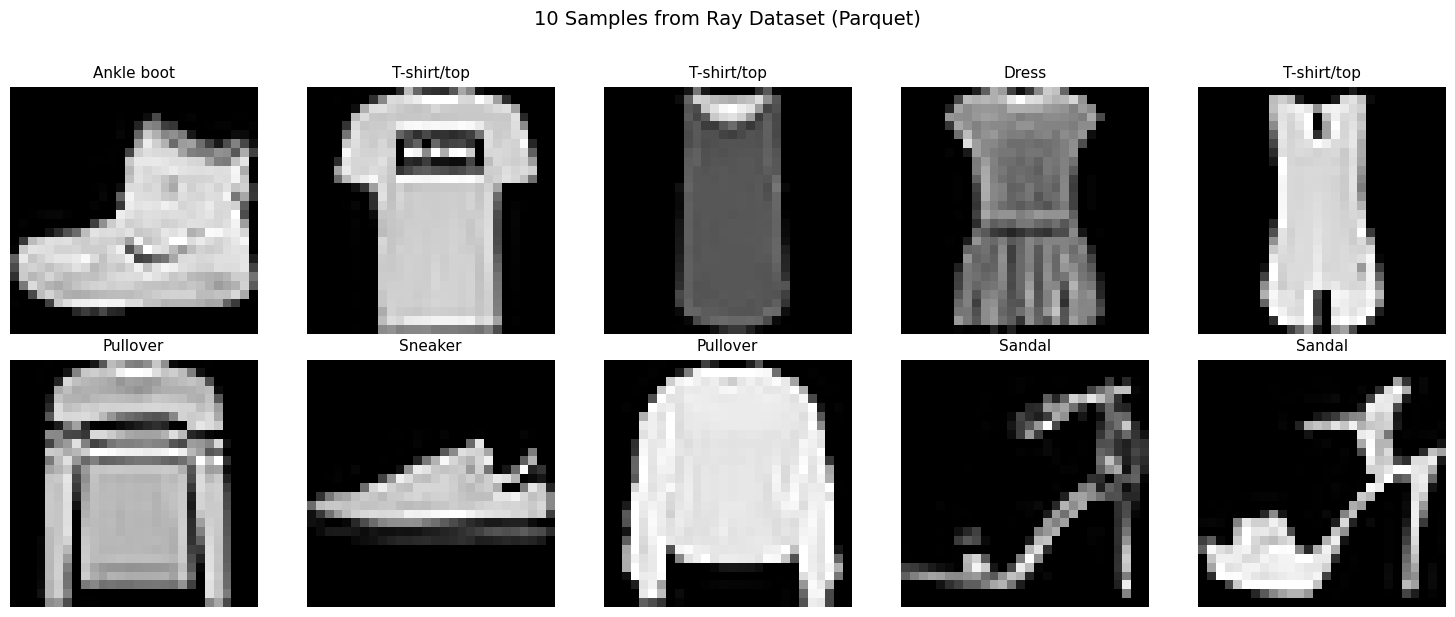

In [9]:
# Visualize samples from Ray Dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

samples = loaded_train_ds.take(10)

for i, (ax, sample) in enumerate(zip(axes, samples)):
    img = sample["image"]
    label = sample["label"]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{train_raw.classes[label]}", fontsize=11)
    ax.axis("off")

plt.suptitle("10 Samples from Ray Dataset (Parquet)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Shutdown

In [ ]:
ray.shutdown()